# t-SNE (t-Distributed Stochastic Neighbor Embedding)

В этой домашней работе предлагается реализовать самостоятельно один из наиболее известных методов понижения размерности t-SNE.

Коротко опишем основные идеи этого метода.

1) На основании расстояний между объектами находим для каждого объекта $i$ распределение его соседей $p_{j|i}$ - с какой вероятностью каждый объект $j$ будет выбран, если мы выбираем соседа для $i$.

2) Случайно вложим все объекты в маломерное пространство и найдем аналогичные распределения.

3) Будем последовательно менять вложение так, чтобы максимально приблизить распределения, полученные на шаге 2, к распределения с шага 1.

Полезные ссылки

- __[статья](https://proceedings.neurips.cc/paper_files/paper/2002/file/6150ccc6069bea6b5716254057a194ef-Paper.pdf)__ про SNE - предшественник t-SNE
- __[статья](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)__ про t-SNE

In [1]:
import numpy as np
from matplotlib import pyplot as plt

### Создаем датасет

Для ускорения вычислений будем использовать небольшой сгенерированный датасет из 1000 объектов трех разных классов с 10 характеристиками.

In [2]:
from sklearn.datasets import make_classification

# Создаем датасет для задачи классификации.
X, labels = make_classification(n_samples=1000, n_features=10, n_informative=7, n_redundant=2, n_classes=3,
                           n_clusters_per_class=1, class_sep=0.8, random_state=42)

In [3]:
X

array([[-0.86207494,  0.92581121, -0.85051586, ...,  1.3466447 ,
        -0.97370357,  1.03863618],
       [-1.04213032, -0.54389395, -0.65487597, ...,  0.98250313,
        -1.4899738 ,  1.72910725],
       [ 2.7301546 , -1.83173791, -0.72221877, ..., -1.36199488,
         1.35470055, -0.49430503],
       ...,
       [-0.06865002, -0.65005551,  0.26304045, ...,  1.03967017,
        -0.12741191,  1.41281878],
       [ 1.4539334 , -0.32074731, -0.09302708, ..., -0.1510914 ,
         0.70775792, -2.06270198],
       [-3.90415137,  0.93678354,  0.01357366, ..., -0.46525608,
        -6.15339198,  4.33340649]])

In [4]:
labels

array([1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2,
       0, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 0, 1, 2, 1, 0, 2, 1, 1, 2, 0,
       0, 1, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 0,
       2, 0, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 0, 0, 1, 1, 2,
       1, 0, 2, 2, 0, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 1, 2, 1, 0,
       1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 0, 0, 0,
       2, 2, 1, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 2, 0, 1,
       2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2, 1, 2, 0, 2, 0,
       1, 2, 0, 0, 2, 0, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1,
       1, 1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 0, 0, 1, 0,
       0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 2,
       2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0,
       2, 1, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 2, 0, 1, 1,
       1, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 2, 1, 1, 2,

### 1. Нормализация данных (1 балл)

Так как t-SNE работает с расстояниями, а мы хотим дальше рассматривать евклидово расстояние, необходимо нормализовать данные. Если этого не сделать, то может оказаться так, что одна характеристика со значениями в тысячах будет практически полностью задавать результат, если у остальных характеристик значения в единицах.

Тут нет готовой эвристики, которая скажет, какая нормализация будет лучше. Мы предлагаем вам вычесть из каждой характеристики ее среднее значение и поделить на среднеквадратичное отклонение.

Подсказка: используйте методы .mean() и .std(), не забывайте про аргумент axis.

In [5]:
def normalize(X_in):
    """
    X_in: np.array (N, D) , где N - количество объектов, а D - количество характеристик.
        В Х по строкам написаны характеристики каждого объекта.
    Выдает np.array размера (N, D) с нормализованными характеристиками каждого объекта.
    """
    X_mean = X_in.mean(axis=0)
    X_std = X_in.std(axis=0)
    X_norm = (X_in - X_mean) / X_std

    return X_norm

In [6]:
X = normalize(X)

In [7]:
X

array([[-0.77484353,  0.65448612, -0.82741   , ...,  1.0950102 ,
        -0.37908785,  0.45979576],
       [-0.8958384 , -0.11198185, -0.6362775 , ...,  0.85090959,
        -0.65263856,  0.7816256 ],
       [ 1.63908803, -0.78360713, -0.70206877, ..., -0.72071378,
         0.85463928, -0.25471096],
       ...,
       [-0.2416723 , -0.16734631,  0.26049085, ...,  0.88923124,
         0.06932786,  0.63420296],
       [ 0.78148397,  0.00439167, -0.08737317, ...,  0.09100975,
         0.51185056, -0.98574368],
       [-2.81907935,  0.66020831,  0.01677157, ..., -0.11958908,
        -3.12359518,  1.99549427]])

In [8]:
def test_normalize():
    X_test = np.random.rand(10, 10)
    X_norm = normalize(X_test)
    assert np.allclose(X_norm.mean(axis=0), 0)
    assert np.allclose(X_norm.std(axis=0), 1)

test_normalize()

### 2. Визуализация (1 балл)
Допишите функцию, plot_classes которая будет отмечать точками разного цвета объекты разных классов. Для этого в качестве координат используйте только значения первых двух характеристик каждого объекта. В дальнейшем мы будем визуализировать не только классы в исходном пространстве, но и их положение после применения t-SNE.

Достаточно базового знания matplotlib, но можно использовать и seaborn.

In [9]:
def plot_classes(X_in, labels=labels):
    """
    X_in : np.array размера (N, D), где N - количество объектов, а D - количество характеристик.
        В Х_in по строкам написаны характеристики каждого объекта.
    labels : np.array размера (N,) - классы объектов, записанные как целые числа.

    Отмечает каждый объект точкой на плоскости, в качестве координат использует первые две характеристики.
    Цвет соответствует классу объекта, записанному в labels.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X_in[:, 0], X_in[:, 1], c=labels)
    plt.title('Визуализация первых двух характеристик')
    plt.xlabel('Характеристика 1')
    plt.ylabel('Характеристика 2')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


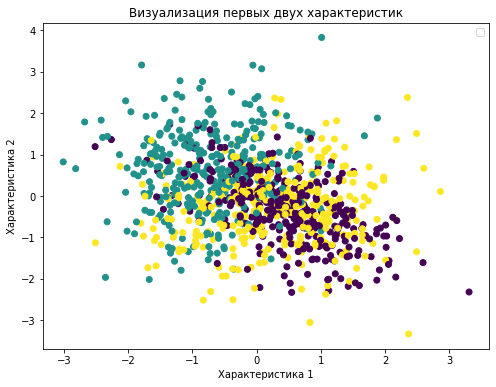

In [10]:
plot_classes(X)

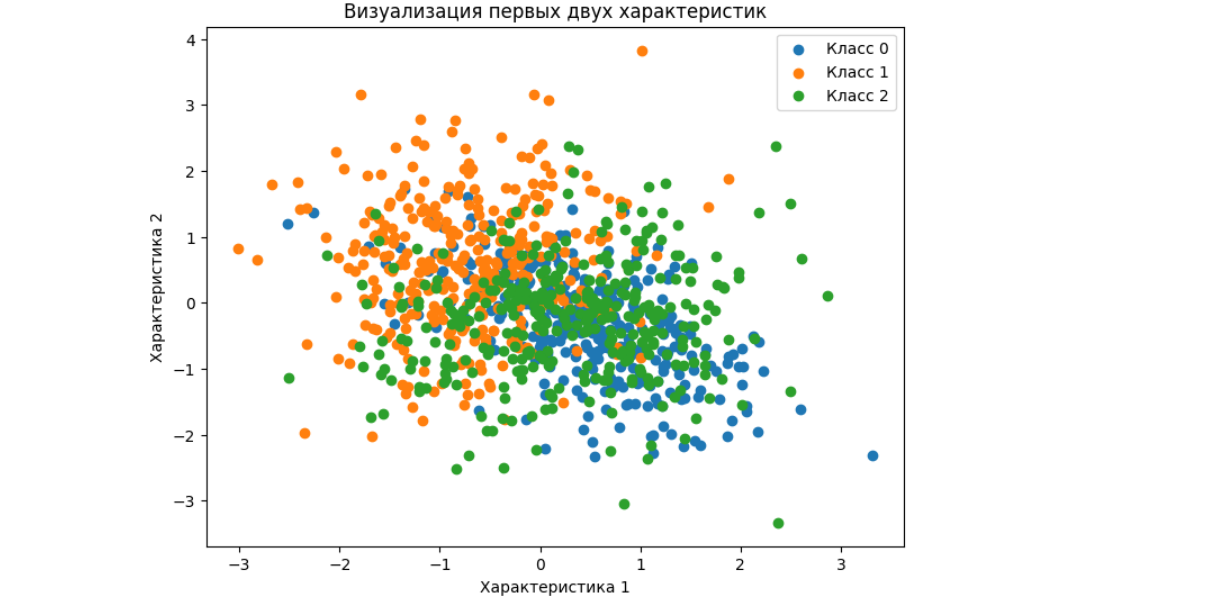

Видим, что классы практически сливаются в такой проекции.

Хочется посмотреть, можно ли их вообще разделить или они слишком сильно пересекаются. Для этого воспользуемся реализацией t-SNE из стандартной библиотеки sklearn

No handles with labels found to put in legend.


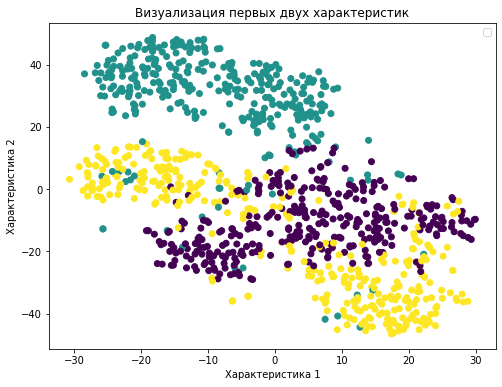

In [11]:
from sklearn.manifold import TSNE

def use_TSNE(X_in):
    tsne = TSNE()
    Y = tsne.fit_transform(X_in)
    plot_classes(Y)

use_TSNE(X)

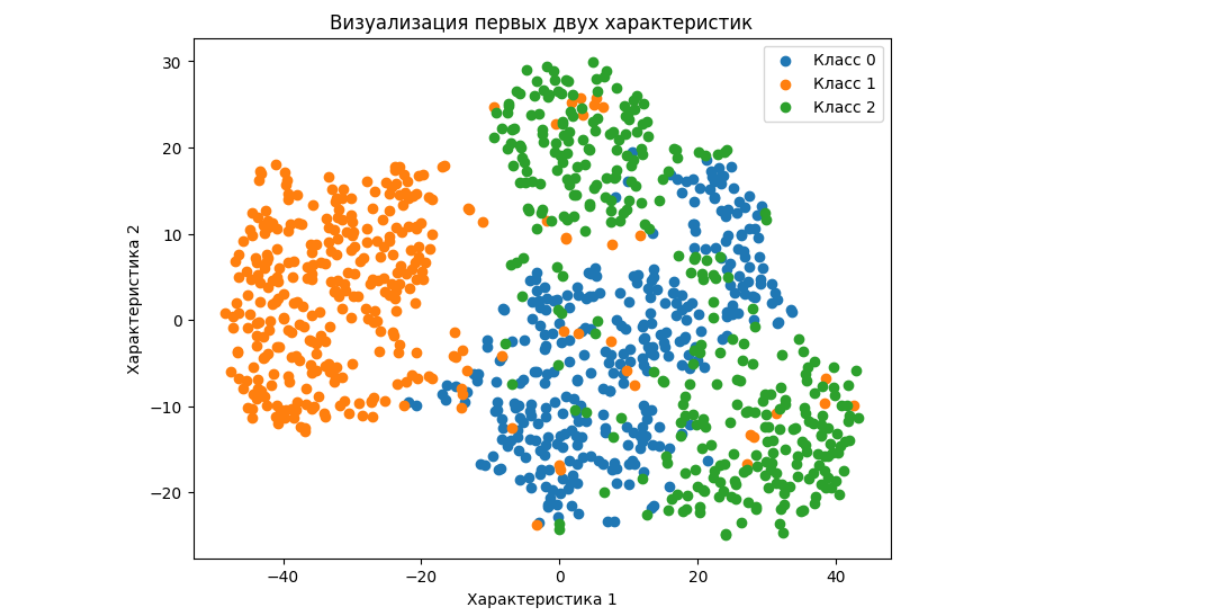

Видим, что классы довольно неплохо отделяются друг от друга.

### 3. Матрица квадратов расстояний (1 балл)

Так в наших вычислениях будут использоваться не расстояния, а квадраты расстояний, то в этой пункте мы просим вас написать функцию, которая по характеристикам будет выдавать квадраты расстояний между объектами.

Нахождение матрицы расстояний - это очень трудоемкая операция для больших датасетов. Конечно, существует множество трюков, как ее решать эффективно или приблизительно. Для наших целей достаточно написать функцию с помощью numpy, которая будет работать достаточно быстро на датасетах с 1000 объектов и не обязательно будет вообще работать на датасетах с 100000 объектов.

Для решения задачи достаточно методов .reshape() и .sum(), а также знания о __[shape broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)__ во время арифметических операций. Можно, конечно, преобразовать формулы и решить этот пункт немного по-другому.

In [12]:
def square_distances(X_in):
    """
    X_in : np.array размера (N, D), где N - количество объектов, а D - количество характеристик.
        В Х_in по строкам написаны характеристики каждого объекта.
    """
    N = X_in.shape[0]
    X_diff = X_in.reshape(N, 1, -1) - X_in.reshape(1, N, -1)
    square_distances = np.sum(X_diff ** 2, axis=2)

    return square_distances

In [13]:
D2 = square_distances(X)

In [14]:
D2

array([[ 0.        , 21.61058445, 15.82384744, ...,  8.6783796 ,
        12.52944994, 22.41770653],
       [21.61058445,  0.        , 27.58982639, ..., 11.19253974,
        19.99240971, 32.74407081],
       [15.82384744, 27.58982639,  0.        , ..., 11.20101933,
         7.8300533 , 49.87539725],
       ...,
       [ 8.6783796 , 11.19253974, 11.20101933, ...,  0.        ,
        13.04737061, 31.72536807],
       [12.52944994, 19.99240971,  7.8300533 , ..., 13.04737061,
         0.        , 44.95887723],
       [22.41770653, 32.74407081, 49.87539725, ..., 31.72536807,
        44.95887723,  0.        ]])

In [15]:
def test_square_distances():
    X_test = np.array([[1,2,3], [1,0,1]])
    D2 = np.array([[0, 8],[8, 0]])
    D2_test = square_distances(X_test)
    assert np.allclose(D2, D2_test)

test_square_distances()

### 4. Вычисляем близости (affinities) используя "Гауссовы окрестности" (1 балл)

В этом пункте мы найдем так называемые affinities - матрицу вероятностей $p_{j|i}$, которые для некоторого объекта $i$ говорят, с какой вероятностью каждый объект $j$ будет выбран соседом $i$. Для этого используют плотность нормального распределения и вероятности выбирают пропорционально значениям плотности в зависимости от расстояния между $i$ и $j$.

$$p_{j|i}=\frac{\exp(-||x_i-x_j|| / 2\sigma_i^2)}{\sum_{k\ne i}exp(-||x_i-x_k||^2 / 2\sigma_i^2)}$$

Здесь $x_i$ - вектор координат объекта $i$, а  $\sigma_i$ - дополнительные параметры, которые мы будем подбирать отдельно в следующем пункте.

Вероятность $p_{j|i}$ нужно записать на пересечении строки $i$ и столбца $j$.

Подсказка: задачу можно свести к вызову функции softmax, если заполнить диагональ -np.inf.

In [16]:
from scipy.special import softmax

def affinities_gauss(D2_in, sigmas=None):
    """
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    sigmas : np.array размера (N,) или None - квадраты sigma_i
      Если None, в качестве квадратов sigma_i берем 1.
    """
    if sigmas is None:
        sigmas = np.ones(D2_in.shape[0])

    P = np.exp(-D2_in / (2 * sigmas**2))
    np.fill_diagonal(P, -np.inf)
    row_sums = P.sum(axis=1, keepdims=True)
    affinities = P / row_sums 
        
    return affinities

In [17]:
P = affinities_gauss(D2)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [18]:
def test_affinities_gauss():
    D2_test = np.array([[0, 1, 2], [1, 0, 1], [2, 1, 0]])
    P_test = np.array([[0.        , 0.62245933, 0.37754067],
       [0.5       , 0.        , 0.5       ],
       [0.37754067, 0.62245933, 0.        ]])
    assert np.allclose(affinities_gauss(D2_test), P_test)

    sigmas = np.array([1, 2, 3])
    P_test2 = np.array([[0.        , 0.62245933, 0.37754067],
       [0.5       , 0.        , 0.5       ],
       [0.45842952, 0.54157048, 0.        ]])
    assert np.allclose(affinities_gauss(D2_test, sigmas), P_test2)

test_affinities_gauss()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


AssertionError: 

### 5. Находим значения $\sigma_i^2$ (1 балл)

Значения этих параметров находятся из условия того, что перплексия каждого из распределений $\{p_{j|i}\}_j$ (для каждого $i$) должна быть равна фиксированному значению, которое является одним из параметров алгоритма.  

Напишите функцию, которая находит перплексию заданного распределения. Не забудьте увеличивать аргумент логарифма на eps=1e-6, чтобы всегда получался корректный результат (логарифм от нуля выдает минус бесконечность). Помните, что в формуле для энтропии используется логарифм по основанию 2 (вспомните формулу замены основания у логарифма).

$$Perplexity(X)=2^H(X), \quad H(X)=-\sum_i p_i \log p_i$$


In [19]:
def perplexity(probabilities, eps=1e-6):
    """
    probabilities : np.array размера (D,) из вероятностей
    eps : float - маленькое положительное число, чтобы избежать log(0)
    """
    H = -np.sum(probabilities * np.log2(probabilities + eps))
    perplexity = 2 ** H

    return perplexity

In [20]:
test_probs = np.array([1/6] * 6)
assert np.allclose(perplexity(test_probs), 6)

С помощью следующей функции можно найти $\sigma_i^2$ с помощью метода деления отрезка пополам, так как перпелексия монтонно зависит от $\sigma_i^2$.  

In [21]:
def perplexity_by_sigma(sigma_sqr, i, D2_in):
    """
    sigma_sqr : float - квадрат сигма
    i - номер объекта, для которого считаем перплексию
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    """
    dist = -D2_in[i].copy() / (2 * sigma_sqr)
    dist[i] = -np.inf
    probabilities = softmax(dist)
    return perplexity(probabilities)

Проверим монотонность зависимости.

Минимальное значение 1.000, максимальное значение 994.845


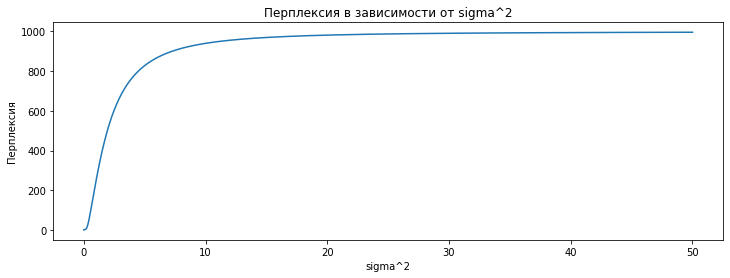

In [22]:
def is_perplexity_monotone():
    sigma_vals = np.linspace(1e-5, 50, 1000)
    perplexity_vals = [perplexity_by_sigma(sigma, i=0, D2_in=D2) for sigma in sigma_vals]
    print(f"Минимальное значение {min(perplexity_vals):.3f}, максимальное значение {max(perplexity_vals):.3f}")
    plt.figure(figsize=(12, 4))
    plt.plot(sigma_vals, perplexity_vals)
    plt.title('Перплексия в зависимости от sigma^2')
    plt.xlabel('sigma^2')
    plt.ylabel('Перплексия')
    plt.show()

is_perplexity_monotone()

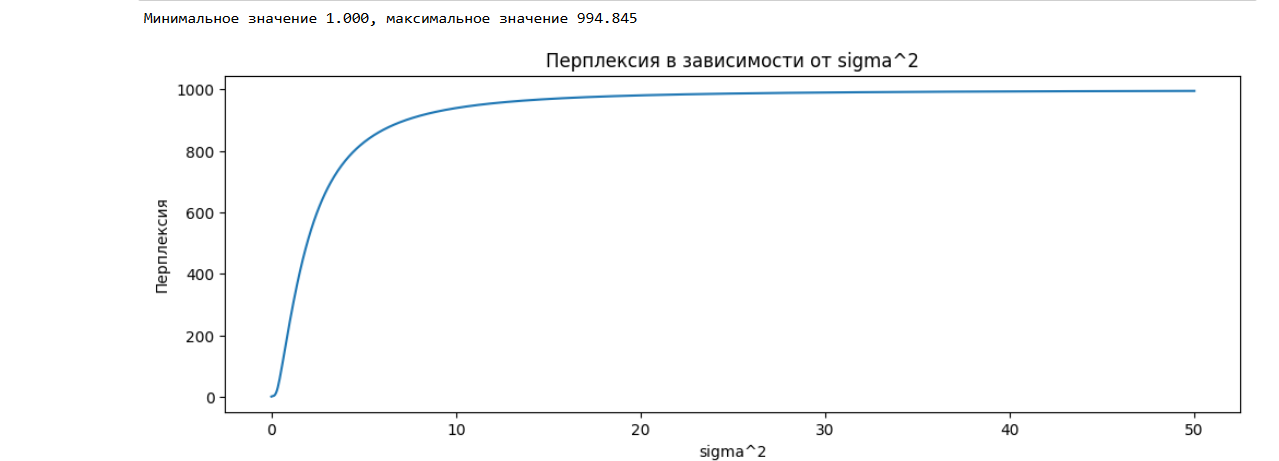

Как видим, перплексия, то есть "эффективное количество значений", меняется от 1 до 1000. Скорее всего вы увидите максимальное значение меньше 1000, потому что на графике присутствуют значения перплексии только для не очень больших значений $\sigma_i^2$.

In [23]:
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, left=1e-10, right=1000.):
    """
    Базовый вариант бинарного поиска, который находит для монотонно возрастающей функции eval_fn
    точку на промежутке (left, right), значение в которой равно target.
    """
    for i in range(max_iter):
        middle = (left + right) / 2.
        val = eval_fn(middle)
        if val > target:
            right = middle
        else:
            left = middle
        if np.abs(val - target) <= tol:
            break
    return middle

In [24]:
from functools import partial # Позволяет заранее завиксировать значения части аргументов функции

def find_sigmas(D2_in, perplexity=30):
    """
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    perplexity : float - значение перплексии
    """
    sigmas = []
    for i in range(D2_in.shape[0]):
        eval_func = partial(perplexity_by_sigma, i=i, D2_in=D2_in)
        sigma = binary_search(eval_func, perplexity)
        sigmas.append(sigma)
    return np.array(sigmas)

### 6. Симметричные близости (1 балл)

Еще одним отличием t-SNE от SNE является использование симметрических близостей вместо близостей. Если близости, найденные ранее, говорили, насколько остальные вершины схожи с некоторой вершиной $i$, то сейчас мы хотим получить некоторую меру схожести для всех пар вершин одновременно. Для этого $p_{j|i}$ вначале симметризуют, а потом нормируют, чтобы получить вероятностное распределение на множестве всех пар $(i,j)$, $i\ne j$.

$$p_{ij} = \frac{p_{j|i}+p_{i|j}}{2 \cdot N}$$

где $N$ - общее количество объектов.

Напишите функцию, которая превращает матрицу $p_{j|i}$ в матрицу $p_{ij}$.

In [25]:
def symmetrise(P_in):
    """
    P_in  : np.array размера (N, N) - матрица вероятностей
    Возвращает матрицу симметричных вероятностей
    """
    P_sym = (P_in + P_in.T) / (2 * P_in.shape[0])

    return P_sym

In [26]:
def test_symmetrise():
    P = np.array([[0, 0.5, 0.5],[0.7, 0, 0.3],[0.9, 0.1, 0]])
    P_sym = np.array([[0, 0.2, 7/30],[0.2, 0, 2/30],[7/30, 2/30, 0]])
    assert np.allclose(symmetrise(P), P_sym)

test_symmetrise()

### 7. Вычисляем близости используя распределение Стьюдента (1 балл)

Вначале t-SNE случайным образом вкладывает все объекты в плоскость (или в другое пространство малой размерности). Затем находит по этому вложению affinities (близости) между точками. А дальше с помощью градиентного спуска двигает точки так, чтобы близости между точками в маломерном пространстве были максимально близки к исходным близостям в многомерном пространстве.

Интересной особенностью t-SNE, которая и дала ему название, является то, что для нахождения симметричных близостей (affinities) $q_{ij}$ в маломерном пространстве используется плостность t-распределения Стьюдента с одной степенью свободы (его еще называют распределением Коши) вместо плотности нормального распределения. При этом конструкция немного более простая. Как мы увидим в следующем пункте, это дает достаточно простые формулы для обновления $y_i$.

$$q_{ij}= \frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\ne l}(1+||y_k-y_l||^2)^{-1}},$$

где  $y_i$ - вектор координат объекта $i$ в маломерном пространстве. Заметим, что суммирование в знаменателе происходит по всем вохможным парам $(k,l)$, где $k\ne l$.

Допишите функцию, которая вычисляет близости между объектами по матрице квадратов расстояний. Трюк с заполнением диагонали -np.inf может оказаться полезным и тут.

In [27]:
def symmetric_affinities_student(D2_in):
    """
    D2_in : np.array размера (N, N) - квадраты расстояний между объектами
    """
    Q = 1 / (1 + D2_in)
    np.fill_diagonal(Q, 0) # использование -np.inf приводит к падению обработки и теста
    total_sum = np.sum(Q)
    affinities = Q / total_sum

    return affinities

In [28]:
Q = symmetric_affinities_student(D2)

In [29]:
def test_symmetric_affinities_student():
    D2_test = np.array([[0, 1., 2], [1, 0, 1], [2, 1, 0]])
    Q_test = np.array([[0.    , 0.1875, 0.125 ],
       [0.1875, 0.    , 0.1875],
       [0.125 , 0.1875, 0.    ]])
    assert np.allclose(symmetric_affinities_student(D2_test), Q_test)

test_symmetric_affinities_student()

In [30]:
Y = np.random.randn(X.shape[0], 2) * 0.01
D2y = square_distances(Y)
Q = symmetric_affinities_student(D2y)

### 8. Дивергенция Кульбака-Лейблера (1 балл)

Для измерения близости распределений $p_{ij}$ и $q_{ij}$ используется дивергенция Кульбака-Лейблера.

$$C=D_{KL}(P||Q) = \sum_{i\ne j} p_{ij}\log\left(\frac{p_{ij}}{q_{ij}}\right)$$

Чем $C$ меньше, тем ближе распределения друг к другу. Поэтому для обновления положений объектов в маломерном пространстве все объекты одновременно двигаются в направлении, противоположном градиенту $C$. К счастью, для градиента $C$ есть уже готовая простая формула.

$$\frac{\delta C}{\delta y_i}=4\sum_j (p_{ij}-q_{ij})(y_i-y_j)(1+||y_i-y_j||^2)^{-1}$$

В этой формуле первый и третий сомножители являются числами, а второй ($y_i-y_j$) - это вектор. Каждое слагаемое в этой формуле можно воспринимать как силу, с которой точка $j$ действует на точку $i$. Эта сила направлена вдоль вектора $y_i-y_j$, соединяющего точки. Заметим, что последний сомножитель гарантирует, что эта сила всегда ограничена по величине. Эта свойство появляется из-за использования t-распределения Стьюдента.

Напишите функцию, вычисляющую градиенты $C$ по всем $y_i$ в виде матрицы. Здесь легко ошибиться в знаке, следите за этим.

In [31]:
def gradient_with_student(P, Q, Y, D2y):
    """
    P : np.array  размера (N, N) - симметричные близости в исходном пространстве
    Q : np.array  размера (N, N) - симметричные близости в маломерном пространстве
    Y : np.array  размера (N, D') - координаты объектов в маломерном пространстве
        Можно держать в уме D'=2
    D2y : np.array  размера (N, N) - квадраты расстояний между объектами в маломерном пространстве

    Выдает gradients : np.array размера (N, D') - матрицу градиентов
    """
    gradients = np.zeros_like(Y)
    for i in range(P.shape[0]):
        for j in range(P.shape[0]):
            if i != j:
                grad_factor = (P[i, j] - Q[i, j]) * (Y[i] - Y[j]) / (1 + D2y[i, j])
                gradients[i] += grad_factor
    gradients = gradients * 4

    return gradients

In [32]:
def test_gradients():
    P = np.array([[0, 0.2, 7/30],[0.2, 0, 2/30],[7/30, 2/30, 0]])
    Y = np.array([[0, 0], [0, 1.], [1, 0]])
    D2y = square_distances(Y)
    Q = symmetric_affinities_student(D2y)
    grad = 4 * np.array([[-0.02291667, -0.00625   ],
       [ 0.01944444, -0.01319444],
       [ 0.00347222,  0.01944444]])
    assert np.allclose(gradient_with_student(P, Q, Y, D2y), grad)

test_gradients()

### 9. Собираем все вместе (2 балла)

В этом пункте вам предстоит дописать методы класса MyTSNE с помощью уже написанных функций. А также написать самостоятельно градиентный спуск с сохранением момента. Он задается следующей формулой:

$$ Y^{(t)}=Y^{(t-1)} - \eta \cdot \frac{\delta C}{\delta Y} + \alpha\cdot(Y^{(t-1)} -Y^{(t-2)}),$$

где $\eta$ - темп обучения (learning rate), а $\alpha$ - коэффициент затухания момента при движении (momentum).

In [33]:
# self, perplexity=30, learning_rate=10, momentum=0.9, num_iters=500, target_dimension=2

С указанными параметрами код не отрабатывал, поэтому понизил значения

In [35]:
class MyTSNE():
    def __init__(self, perplexity=10, learning_rate=3, momentum=0.6, num_iters=100, target_dimension=2):
        """
        perplexity : float - значение perplexity
        learning_rate :float - темп обучения
        momentum : float из (0, 1) - коэффициент сохранения момента у граждиентного спуска
        num_iters : int - количество итераций градиентного спуска
        target_dimension : int не меньше 1 - размерность пространства, в котором мы хотим расположить объекты
        """
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.num_iters = num_iters
        self.target_dimension = target_dimension

    def fit_transform(self, X):
        """

        """

        # 1) Нормализуем характеристики
        # 2) Находим квадраты расстояний между ними
        # 2) Находим сигмы
        # 3) Находим близости в исходном пространстве
        # 4) Находим симметрические близости в исходном пространстве

        X = normalize(X)
        D2 = square_distances(X)
        sigmas = find_sigmas(D2, perplexity=self.perplexity)
        P = affinities_gauss(D2, sigmas=sigmas)
        P_sym = symmetrise(P)        

        # Инициализируем положения объектов в маломерном пространстве из распределения N(0, 0.0001)
        Y = np.random.randn(X.shape[0], self.target_dimension) * 0.01

        # Инициализируем значения Y^(t-2) и Y^(t-1)
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()

        # Начинаем градиентный спуск
        for i in range(self.num_iters):

            # 5) Находим квадраты расстояний по Y
            # 6) Находим симметрические близости в маломерном пространстве
            # 7) Находим градиенты С

            D2y = square_distances(Y)
            Q = symmetric_affinities_student(D2y)
            grad = gradient_with_student(P_sym, Q, Y, D2y)

            # 8) Обновляем Y c помощью градиента используя self.learning_rate и self.momentum
            # Важно обновлять значение Y с помощью присваивания (Y = ...), а не с помощью операций += и -=,
            # чтобы изменение Y не затронуло Y_m1 и Y_m2, которые могут указывать на тот же массив.

            Y = Y_m1 - self.learning_rate * grad + self.momentum * (Y_m1 - Y_m2)

            # Обновляем значения Y^(t-2) и Y^(t-1)

            Y_m2 = Y_m1
            Y_m1 = Y

        return Y

Давайте проверим, что получилось

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
No handles with labels found to put in legend.


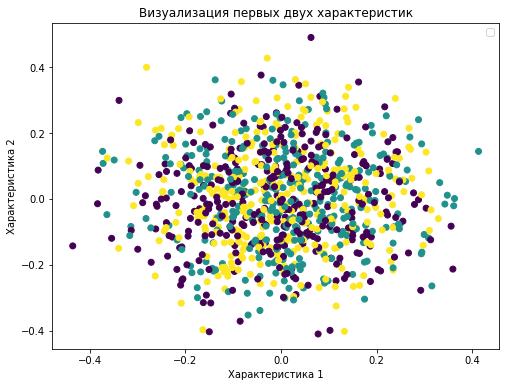

In [36]:
np.random.seed(42)  # Фиксируем состояние генератора случайных чисел для воспроизводимости
my_tsne = MyTSNE()
Y = my_tsne.fit_transform(X)
plot_classes(Y)

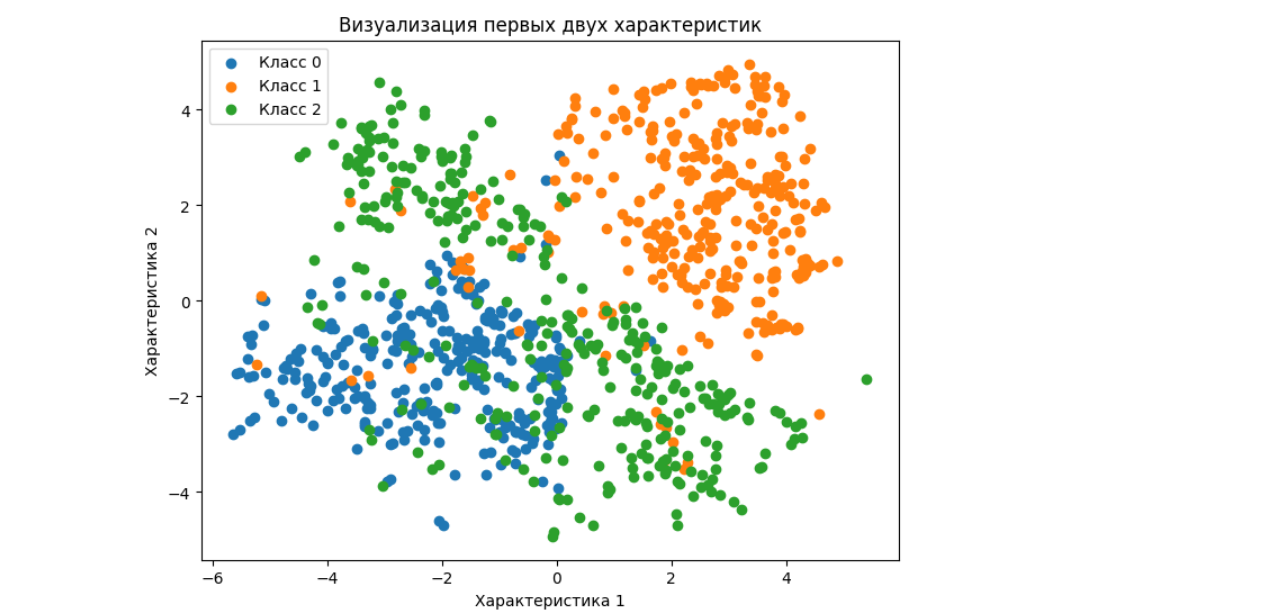

Классы достаточно хорошо отделены друг от друга!
Если хочется лучшего результата, попробуйте поперебирать значения параметров.


Поздравляем с успешным завершением задания!

### 10. (Бонус) Uniform Manifold Approximation and Projection (UMAP) (1 балл)

UMAP является еще одним известным методом понижения размерности.

Установите библиотеку umap-learn, разберитесь как ее использовать и примените UMAP для понижения размерности нашего сгенерированного датасета. Сравните результаты с t-SNE. Что вы можете сказать о результатах?